# DCGAN for MNIST (PyTorch)

arXiv: https://arxiv.org/abs/1511.06434

<img src="https://lh3.googleusercontent.com/M0D8jzjxyELjUFLVyZYF0UQVuYyLywwIorNRhyOwSeOsATqK_tOZS3cHAnHZSP5I-fmjSCFGB5Ztrxmd7SJpY2amIXOox7H_OVZhGZMqdGk5yUcrDK4Qh5941rMLfW_N67eNAyetS0lB6LlAShsdtqGJCfBrW5a7EBXJnmpM0v640_5-xFDgsxIaC5IliQqSxoz5cYhK14d3tG2V_Qa39CZ4yKlQNnZb0OhWRTezWoFQ3uZdK2RQHQ22PA3CrEW27kTVl95688fhA1EKvZloEZ7YZolxErdsx9Lc3zcE8kiI0gmqErKSsOOImwnL9ESC6rPosze4CSvs8-bSUOLXMyO8fQIDvObuRFfYT6TAflAYSp8PXCevA2LhvUCFat5YV5N6XpFmKoZam6w-lX8koEEeZI6djv8z5eETO3ab1Fhn7_UB1hper6kScrtj_4CRdeP_mvuALhRQvEB81_jV6N5KIFTJ2b7oCoo8to32XZvmk42w6IR8WasMtOQJB3yeKWY5mGAtoLOpuJ4H7r0KAXxbaHpDvltlIR227Ria2-7FSfSJTnaA3bv1MjHpLALaNnelZAwySJynzP0lof8kz9EiQCsjSL2TN-pudLC7jWHnyy-3FAKuj6sK=w807-h208-no">

<img src="https://lh3.googleusercontent.com/CqWKmMExGj3Ws9_vYROf2hnnV-HH5hlzvga0Dv_NrHXZKTwoSFWNZ4GO3ee9dVar-kCZmNkpLxkTZ9dLQj9uKeY__ys608i7jfWQqoIRrF2NU-ESZBiWbSxqeEwOICy-W-oWYDAK9Cxse4JPOoWOxFrfaMaNg-cC7UsJCa-PTtt8G11wENorShWIaa2_2dAwn92kaPj8bABqKLRuDEcOxwLdZpnGQOWZPRNgVprefoStGMnfpyRXb9fx-yoBhgSExMv-ybPZLbbymZ8PdMY8bCiNZZ0MRvjvRe-hYGJ_4fWwjmNRaB2ixKLjaaM0Ha2xLA3G_zbpfEo9ygLGIufntEWX6M3mXz-ctK3QrninW3Bfia1IYNQFKJUVnaGvZf6-bFswghn-ody073j89m6fYYysYrVzxxE9HQJeKGuwQKBkG1e7mG1PPwnr-hovxLiHRduMmi0BjNYxOtSYkffBPYzR9n8h66qC-AepoKAGO-Z7LBAuBKpwflhih1Ho9ttBRxBYTwkVeYOMIV8aQkNNY9CKbC-VazHnN7x-eWV0us2tDrJCOcYU3wjBMi-76oalxldFxQQ9MQy1x5SWkiI6vEW_hCbaAlWGJB3bud91PbciIuTk-LIH9Nh4=w805-h350-no">

Deep Convolution GANに以下の改善を行う。
- すべてのプーリングレイヤを strided convolutions(discriminator)と fractional-stirided convolutions(generator)に変更する。
- generator と discriminator に batchnormを使う。
- 全結合隠れ層を取り除く。
- ReLU 活性関数を generatorで使う。ただし、output層は tanhを使う。
- LeakyReLU活性関数をdiscriminatorのすべての層で使う。

もとい！

公式チュートリアルにサンプルコードが公開されているので、それを参考に実装する。
- [examples/dcgan at master · pytorch/examples](https://github.com/pytorch/examples/tree/master/dcgan)

In [2]:
% matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

if torch.cuda.is_available():
    import torch.cuda as t
else:
    import torch as t

import torchvision
from torchvision import datasets, models, transforms, utils
import torchvision.utils as vutils

import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import os

## mnist datasetの準備

In [2]:
bs = 100
sz = 32

In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
imagenet_data = ImageFolder('/home/ubuntu/cutting-edge-dl-for-coders-part2/data/default/', 
                            transform=transforms.Compose([
                            transforms.Scale(sz),
                            transforms.ToTensor()]))
dataloader = torch.utils.data.DataLoader(imagenet_data,
                                         batch_size=bs,
                                         shuffle=True)

## Model

In [7]:
nz = 100
ngf = 32
ndf = 32
nc = 3

In [8]:
'''Discriminater'''
class netD(nn.Module):
    def __init__(self):
        super(netD, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1 , 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        #x = x.view(100, -1)
        x = self.main(x)
        return x

'''Generator'''
class netG(nn.Module):
    def __init__(self):
        super(netG, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf,nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        # x = x.view(bs,100)
        x = self.main(x)
        #x = x.view(-1, 1, sz, sz)
        return x

In [9]:
criteion = nn.BCELoss()
net_D = netD()
net_G = netG()

if torch.cuda.is_available():
    D = net_D.cuda()
    G = net_G.cuda()
    criteion = criteion.cuda()    

In [10]:
print(net_D)

netD (
  (main): Sequential (
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid ()
  )
)


In [11]:
print(net_G)

netG (
  (main): Sequential (
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh ()
  )
)


In [12]:
optimizerD = optim.Adam(net_D.parameters(), lr = 0.00005)
optimizerG = optim.Adam(net_G.parameters(), lr = 0.00005)

## Train

In [13]:
input = t.FloatTensor(bs, nc, sz, sz)
noise = t.FloatTensor(normal(0, 1, (bs, 100, 1, 1)))
fixed_noise = t.FloatTensor(bs, 100, 1, 1).normal_(0, 1)
label = t.FloatTensor(bs)

real_label = 1
fake_label = 0

input = Variable(input)
label = Variable(label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)

In [14]:
niter = 4000

In [ ]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real (data)
        net_D.zero_grad()
        real, _ = data
        input.data.resize_(real.size()).copy_(real)
        label.data.resize_(bs).fill_(real_label)
        output = net_D(input)
        errD_real = criteion(output, label)
        errD_real.backward()
        D_x = output.data.mean()

        #train with fake (generated)
        noise.data.resize_(bs, 100, 1, 1)
        noise.data.normal_(0, 1)
        fake = net_G(noise)
        label.data.fill_(fake_label)
        output = net_D(fake.detach())
        errD_fake = criteion(output, label)
        errD_fake.backward()
        D_G_z1 = output.data.mean()

        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        net_G.zero_grad()
        label.data.fill_(real_label)
        output = net_D(fake)
        errG = criteion(output, label)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()
        
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, niter, i, len(dataloader),
                     errD.data[0], errG.data[0],  D_x, D_G_z1, D_G_z2))
    if epoch % 10 == 0:
        fake = net_G(fixed_noise)
        vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png'
                              % ('results', epoch),normalize=True)

[0/4000][0/100] Loss_D: 0.4049 Loss_G: 1.6940 D(x): 0.8760 D(G(z)): 0.2310 / 0.1891
[1/4000][0/100] Loss_D: 0.2647 Loss_G: 2.2955 D(x): 0.8981 D(G(z)): 0.1360 / 0.1052
[2/4000][0/100] Loss_D: 0.3044 Loss_G: 2.3675 D(x): 0.8820 D(G(z)): 0.1496 / 0.1069
[3/4000][0/100] Loss_D: 0.3290 Loss_G: 2.3378 D(x): 0.8591 D(G(z)): 0.1450 / 0.1067
[4/4000][0/100] Loss_D: 0.4345 Loss_G: 2.4491 D(x): 0.7695 D(G(z)): 0.1272 / 0.0943
[5/4000][0/100] Loss_D: 0.4679 Loss_G: 2.1508 D(x): 0.8217 D(G(z)): 0.2107 / 0.1351
[6/4000][0/100] Loss_D: 0.2948 Loss_G: 2.7199 D(x): 0.8445 D(G(z)): 0.1039 / 0.0771
[7/4000][0/100] Loss_D: 0.4960 Loss_G: 2.2441 D(x): 0.7508 D(G(z)): 0.1524 / 0.1188
[8/4000][0/100] Loss_D: 0.3113 Loss_G: 2.7032 D(x): 0.8493 D(G(z)): 0.1237 / 0.0773
[9/4000][0/100] Loss_D: 0.1932 Loss_G: 3.0354 D(x): 0.9071 D(G(z)): 0.0833 / 0.0543
[10/4000][0/100] Loss_D: 0.3096 Loss_G: 2.9119 D(x): 0.8532 D(G(z)): 0.1135 / 0.0691
[11/4000][0/100] Loss_D: 0.2173 Loss_G: 3.0430 D(x): 0.9015 D(G(z)): 0.0969

[97/4000][0/100] Loss_D: 0.4624 Loss_G: 2.5559 D(x): 0.8429 D(G(z)): 0.1850 / 0.1312
[98/4000][0/100] Loss_D: 0.8268 Loss_G: 1.7519 D(x): 0.7016 D(G(z)): 0.2773 / 0.2533
[99/4000][0/100] Loss_D: 0.2922 Loss_G: 2.7660 D(x): 0.9084 D(G(z)): 0.1478 / 0.1075
[100/4000][0/100] Loss_D: 0.7438 Loss_G: 2.0123 D(x): 0.7910 D(G(z)): 0.3033 / 0.2102
[101/4000][0/100] Loss_D: 0.4372 Loss_G: 3.0693 D(x): 0.7928 D(G(z)): 0.1104 / 0.0813
[102/4000][0/100] Loss_D: 0.6588 Loss_G: 1.9957 D(x): 0.7769 D(G(z)): 0.2504 / 0.2211
[103/4000][0/100] Loss_D: 0.5444 Loss_G: 2.4065 D(x): 0.7951 D(G(z)): 0.1959 / 0.1473
[104/4000][0/100] Loss_D: 0.3335 Loss_G: 2.6539 D(x): 0.8638 D(G(z)): 0.1341 / 0.1112
[105/4000][0/100] Loss_D: 0.5204 Loss_G: 2.7411 D(x): 0.7603 D(G(z)): 0.1466 / 0.1064
[106/4000][0/100] Loss_D: 0.4321 Loss_G: 2.8949 D(x): 0.8305 D(G(z)): 0.1571 / 0.1128
[107/4000][0/100] Loss_D: 0.4448 Loss_G: 2.2005 D(x): 0.8652 D(G(z)): 0.2115 / 0.1790
[108/4000][0/100] Loss_D: 0.6347 Loss_G: 2.1106 D(x): 0.7

In [ ]:
fake = net_G(fixed_noise)
vutils.save_image(fake.data[:64], '%s/fake_samples4.png' % 'results' ,normalize=True)

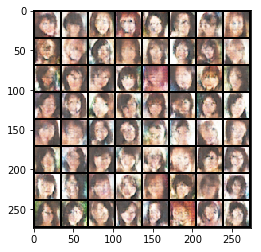

In [3]:
from PIL import Image
im = Image.open("results/fake_samples4.png", "r")
plt.imshow(np.array(im))